In [1]:
import numpy as np
import torch
import torchvision
from torchvision import transforms as T
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 1. Метрика IoU и алгоритм NMS.

## (a) Реализация функции IoU

In [2]:
def compute_iou(box1, box2):
    """
    Вычисление Intersection over Union (IoU) для двух bounding boxes.
    
    Формат bounding box: [x1, y1, x2, y2] (верхний левый и нижний правый углы)
    """
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2
    
    # Координаты пересечения
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)
    
    # Площадь пересечения
    inter_width = max(0, inter_x_max - inter_x_min)
    inter_height = max(0, inter_y_max - inter_y_min)
    inter_area = inter_width * inter_height
    
    # Площади каждого бокса
    area1 = (x1_max - x1_min) * (y1_max - y1_min)
    area2 = (x2_max - x2_min) * (y2_max - y2_min)
    
    # Площадь объединения
    union_area = area1 + area2 - inter_area
    
    # IoU
    iou = inter_area / union_area if union_area > 0 else 0.0
    return iou

## (b) Реализация алгоритма NMS

In [24]:
def non_max_suppression(boxes, scores, iou_threshold=0.5):
    boxes = np.array(boxes)
    scores = np.array(scores)
    
    # Сортируем боксы по убыванию confidence score
    indices = np.argsort(scores)[::-1]
    keep = []
    
    while len(indices) > 0:
        current = indices[0]
        keep.append(current)
        
        # Вычисляем IoU текущего бокса с остальными
        ious = np.array([compute_iou(boxes[current], boxes[i]) for i in indices[1:]])
        
        # Оставляем только боксы с IoU меньше порога
        mask = ious < iou_threshold
        indices = indices[1:][mask]
    
    return boxes[keep], scores[keep]

## (c) Тестирование IoU и NMS

In [ ]:
# Тестовые данные
boxes = [
    [10, 10, 50, 50],  
    [20, 20, 60, 60],   
    [100, 100, 150, 150], 
    [15, 15, 55, 55]    
]

scores = [0.9, 0.8, 0.95, 0.7]

# Применяем NMS с порогом IoU = 0.5
filtered_boxes, filtered_scores = non_max_suppression(boxes, scores, iou_threshold=0.5)

print("Исходные боксы:", boxes)
print("Исходные scores:", scores)
print("Оставшиеся боксы после NMS:", filtered_boxes.tolist())
print("Оставшиеся scores:", filtered_scores.tolist())

Исходные боксы: [[10, 10, 50, 50], [20, 20, 60, 60], [100, 100, 150, 150], [15, 15, 55, 55]]
Исходные scores: [0.9, 0.8, 0.95, 0.7]
Оставшиеся боксы после NMS: [[100, 100, 150, 150], [10, 10, 50, 50], [20, 20, 60, 60]]
Оставшиеся scores: [0.95, 0.9, 0.8]


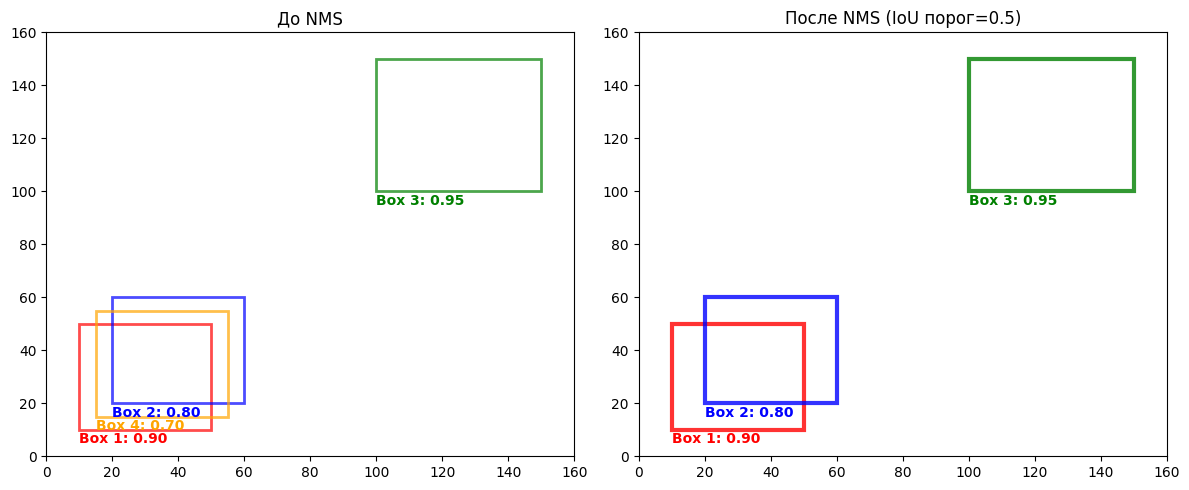

Сохранено боксов: 3 из 4
Удалено боксов: 1


In [5]:
# Простая визуализация
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Цвета для боксов
colors = ['red', 'blue', 'green', 'orange']

# Визуализация исходных боксов
ax1.set_title('До NMS')
ax1.set_xlim(0, 160)
ax1.set_ylim(0, 160)

for i, (box, score) in enumerate(zip(boxes, scores)):
    x1, y1, x2, y2 = box
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                            linewidth=2, edgecolor=colors[i], 
                            facecolor='none', alpha=0.7)
    ax1.add_patch(rect)
    ax1.text(x1, y1-5, f'Box {i+1}: {score:.2f}', 
             fontsize=10, fontweight='bold', color=colors[i])

# Визуализация боксов после NMS
ax2.set_title('После NMS (IoU порог=0.5)')
ax2.set_xlim(0, 160)
ax2.set_ylim(0, 160)

for i, (box, score) in enumerate(zip(filtered_boxes, filtered_scores)):
    x1, y1, x2, y2 = box
    # Находим исходный индекс бокса
    original_idx = boxes.index(box.tolist())
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                            linewidth=3, edgecolor=colors[original_idx], 
                            facecolor='none', alpha=0.8)
    ax2.add_patch(rect)
    ax2.text(x1, y1-5, f'Box {original_idx+1}: {score:.2f}', 
             fontsize=10, fontweight='bold', color=colors[original_idx])

plt.tight_layout()
plt.show()

print(f"Сохранено боксов: {len(filtered_boxes)} из {len(boxes)}")
print(f"Удалено боксов: {len(boxes) - len(filtered_boxes)}")

# 2. Обнаружение объектов с помощью предобученной модели.

## (a) Выберите предобученную модель для обнаружения объектов

Используем Faster R-CNN из torchvision, предобученную на MS COCO


## (b) Загрузка модели и тестирование

In [17]:
# Загрузка предобученной модели
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Загрузка и подготовка изображения
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([T.ToTensor()])
    return transform(image).unsqueeze(0)

# Пример изображения (можно заменить на своё)
image_path = "test_3_1.png"  
image_tensor = load_image(image_path)

# Предсказание
with torch.no_grad():
    predictions = model(image_tensor)


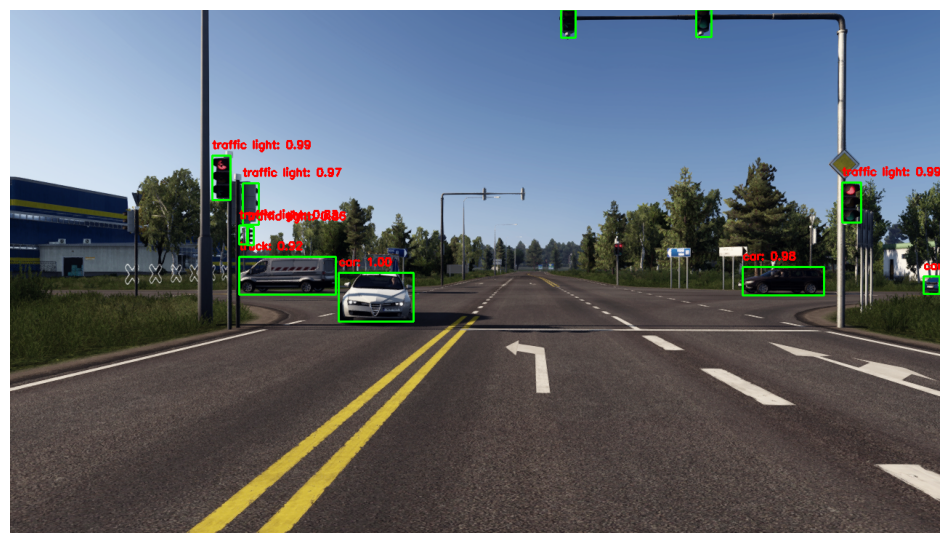

In [18]:
def plot_predictions(image_path, predictions, threshold=0.5):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    boxes = predictions[0]['boxes'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()
    
    # Фильтрация по порогу уверенности
    keep = scores >= threshold
    boxes = boxes[keep]
    scores = scores[keep]
    labels = labels[keep]
    
    # Классы COCO
    COCO_CLASSES = [
        '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
        'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
        'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
        'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
        'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
        'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
        'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut',
        'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A',
        'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock',
        'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
    ]
    
    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box.astype(int)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        label_text = f"{COCO_CLASSES[label]}: {score:.2f}"
        cv2.putText(image, label_text, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

plot_predictions(image_path, predictions, threshold=0.7)

## (d) Исследование влияния порога уверенности


Порог уверенности: 0.9


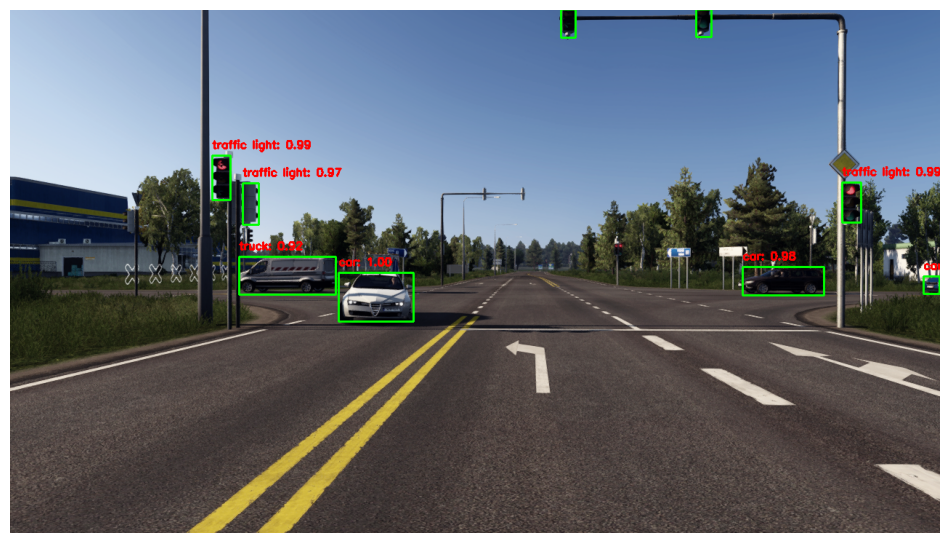


Порог уверенности: 0.2


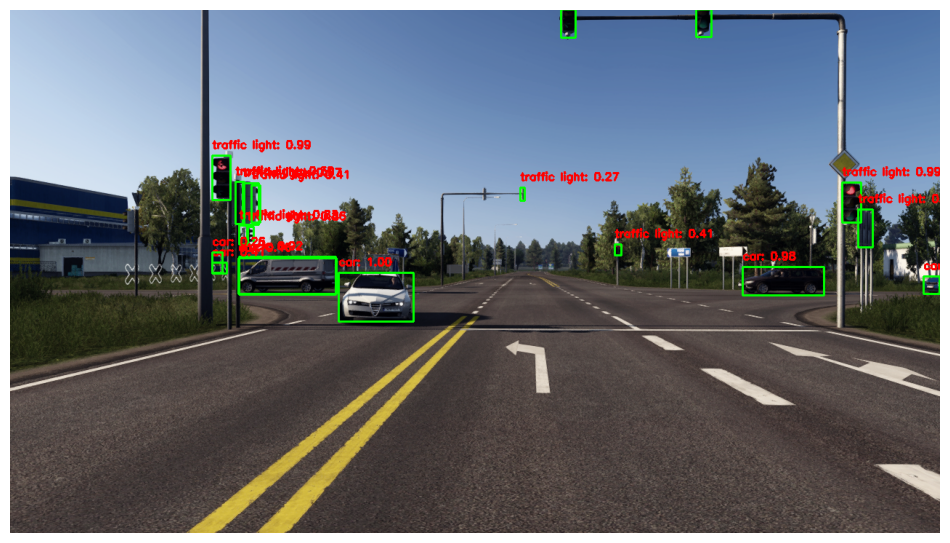

In [20]:
for threshold in [0.9, 0.2]:
    print(f"\nПорог уверенности: {threshold}")
    plot_predictions(image_path, predictions, threshold=threshold)

### Выводы

Добавились ложные срабатывания на левом столбе световора: модель определила балку как несколько светофоров, знаки ограниченности мира, как машины. Помимо этих ошибочных срабатываний, модель заметила еще парочку дальних светофоров. При большем значении порога модель отобразила только ближние объекты с высоким уровнем уверенности 


# Задание 3: Семантическая vs. позкземплярная сегментация


## (a) Выбор моделей

- Для семантической сегментации: DeepLabv3 с ResNet50

- Для instance-сегментации: Mask R-CNN

## (b) Применение моделей

In [22]:
# Загрузка моделей
semantic_model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True).eval()
instance_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True).eval()

# Загрузка изображения
image = Image.open(image_path).convert("RGB")
transform = T.Compose([T.ToTensor()])
img_tensor = transform(image).unsqueeze(0)

# Предсказание для семантической сегментации
with torch.no_grad():
    semantic_out = semantic_model(img_tensor)['out'][0]
    semantic_mask = torch.argmax(semantic_out, dim=0).cpu().numpy()

# Предсказание для instance-сегментации
with torch.no_grad():
    instance_out = instance_model(img_tensor)

print("Семантическая сегментация: маска размером", semantic_mask.shape)
print("Instance-сегментация: обнаружено объектов:", len(instance_out[0]['labels']))

Семантическая сегментация: маска размером (720, 1280)
Instance-сегментация: обнаружено объектов: 30


## (c) Визуализация результатов

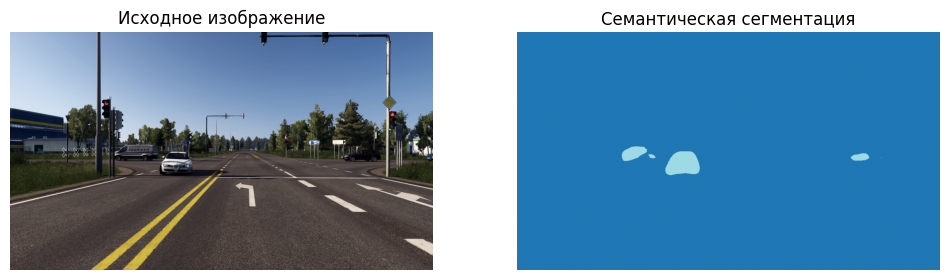

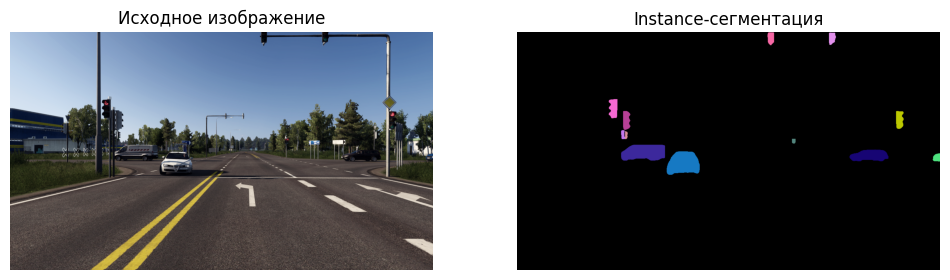

In [23]:
def visualize_semantic(image, mask):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Исходное изображение")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='tab20')
    plt.title("Семантическая сегментация")
    plt.axis('off')
    plt.show()

def visualize_instance(image, predictions, threshold=0.5):
    image = np.array(image)
    masks = predictions[0]['masks'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()
    
    keep = scores >= threshold
    masks = masks[keep]
    
    colored_mask = np.zeros_like(image, dtype=np.uint8)
    
    for i, mask in enumerate(masks):
        color = np.random.randint(0, 255, 3)
        colored_mask[mask[0] > 0.5] = color
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Исходное изображение")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(colored_mask)
    plt.title("Instance-сегментация")
    plt.axis('off')
    plt.show()

visualize_semantic(image, semantic_mask)
visualize_instance(image, instance_out, threshold=0.5)

### Выводы по заданию 3:

1. Семантическая сегментация: присваивает каждому пикселю класс, не различая отдельные объекты одного класса. Из примера видно, что все объекты окрашены одним цветом.

2. Instance-сегментация: выделяет каждый объект отдельно, присваивая уникальную маску и bounding box. Это позволяет считать количество объектов одного класса и четко определять к какому классу относится выделенный объект.

3. Отличия между моделями: Семмантическая сегментация отображает все найденные объекты, а Instance-сегментация какие и где были найдены объекты на изображении.

4. Для instance-сегментации требуется комбинация детекции bounding box и построение маски внутри бокса, что реализовано в Mask R-CNN.

5. При наличии перекрывающихся объектов одного класса семантическая сегментация объединяет их, а instance-сегментация разделяет.
